# Wines Points prediction 

Submission Date : 3.6.2023
Task: Predict the wine score given the inputs
Instructions:
 * Use logistic regression as benchmark model
 * Use sklearn pipeliens + cv + grid search with sklearn models (e.g. KNNs, RandomForest, etc.)
 * Compare all models on proper metric (your choice)

For DNN course project:
* Use sklearn pipeliens with tensorflow models (w/wo embeddings, LSTMs, RNNs, Transformers etc.)
* Compare all models on proper metric (your choice)

In [1]:
#%load_ext autoreload
#%autoreload 2
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')


In [2]:
import nltk
import sys; sys.path.append('../')

In [3]:
import string
import emoji
import re as regex
from pandas import * 

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

#### Loading the data

In [4]:
import pandas as pd
import cufflinks as cf; cf.go_offline()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

In [5]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv", index_col=0)
wine_reviews.shape

(129971, 13)

In [6]:
wine_reviews.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
wine_reviews.describe(include="all")

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,129908,129971,92506,129971.000000,120975.000000,129908,108724,50511,103727,98758,129971,129970,129971
unique,43,119955,37979,NaN,NaN,425,1229,17,19,15,118840,707,16757
top,US,"Seductively tart in lemon pith, cranberry and ...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,54504,3,2009,NaN,NaN,36247,4480,11065,25514,25514,11,13272,222
mean,NaN,NaN,NaN,88.447138,35.363389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,3.039730,41.022218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Is the points normally distributed

(array([0.00305453, 0.00532426, 0.01412623, 0.02327442, 0.04985728,
        0.07332405, 0.0969447 , 0.13028291, 0.13239107, 0.09406714,
        0.11856491, 0.08739642, 0.07396265, 0.04992652, 0.02891414,
        0.01181033, 0.00402397, 0.00176193, 0.00059244, 0.00040009]),
 array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
         91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.]),
 <BarContainer object of 20 artists>)

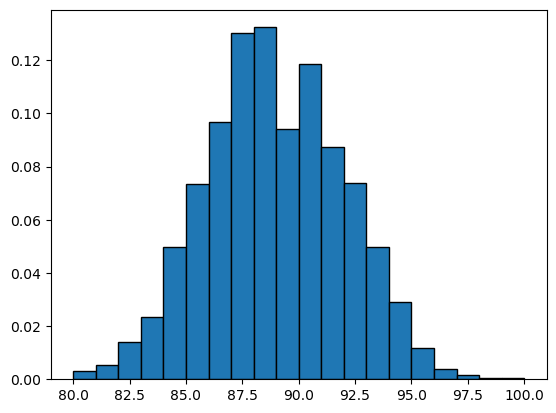

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(wine_reviews.points, edgecolor='black', bins=20, density=True)

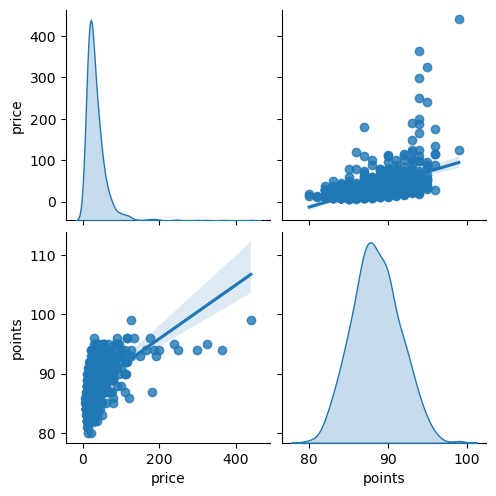

In [9]:
import seaborn as sns
sns.pairplot(wine_reviews[['price','points']].sample(1000), kind="reg", diag_kind="kde")

In [10]:
from scipy.stats import shapiro 
import math
#perform Shapiro-Wilk test for normality
result = shapiro(wine_reviews.points.sample(1000))
result

ShapiroResult(statistic=0.9885647892951965, pvalue=4.970610802956799e-07)

If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
Conclusion - the points are not distributed normally

#### Analize categorical columns

In [11]:
wine_reviews.nunique()

country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

In [12]:
wine_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [13]:
#country
print(wine_reviews.country.value_counts().shape)
country_count = wine_reviews.province.value_counts().sort_values(ascending=False)
country_count.head(10)

(43,)


California          36247
Washington           8639
Bordeaux             5941
Tuscany              5897
Oregon               5373
Burgundy             3980
Northern Spain       3851
Piedmont             3729
Mendoza Province     3264
Veneto               2716
Name: province, dtype: int64

In [14]:
#province
print(wine_reviews.province.value_counts().shape)
province_count = wine_reviews.province.value_counts().sort_values(ascending=False)
province_count_sum = province_count.sum()
#print(province_count.head(50))
province_count.head(50).sum()/province_count_sum

(425,)


0.9111909967053607

In [15]:
#veriety
print(wine_reviews.variety.value_counts().shape)
veriety_count = wine_reviews.variety.value_counts().sort_values(ascending=False)
veriety_count_sum = veriety_count.sum()
#print(veriety_count.head(50))
veriety_count.head(100).sum()/veriety_count_sum

(707,)


0.9471724244056321

In [16]:
print(wine_reviews.winery.value_counts().shape)
winery_count = wine_reviews.winery.value_counts().sort_values(ascending=False)
print(winery_count.head(20))
n = 1000
print(f'{n} sum: {winery_count.head(n).sum()} all sum: {winery_count.sum()} percent: {winery_count.head(n).sum()/winery_count.sum()}')
#there are many different values in the winery and small amount of reviews for each

(16757,)
Wines & Winemakers            222
Testarossa                    218
DFJ Vinhos                    215
Williams Selyem               211
Louis Latour                  199
Georges Duboeuf               196
Chateau Ste. Michelle         194
Concha y Toro                 164
Columbia Crest                159
Kendall-Jackson               130
Siduri                        126
Gary Farrell                  125
Lynmar                        118
Montes                        117
Albert Bichot                 117
Trapiche                      113
Undurraga                     113
Casa Santos Lima              113
Jean-Luc and Paul Aegerter    113
Santa Ema                     112
Name: winery, dtype: int64
1000 sum: 47584 all sum: 129971 percent: 0.3661124404674889


In [17]:
wine_reviews.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

#### Remove categorical columns with too much categoris

In [18]:
reviews = wine_reviews.dropna(subset={'country', 'variety'})
reviews.drop(['taster_twitter_handle','title','designation','region_2','region_1'],axis=1, inplace=True)
reviews.drop(['winery'], axis = 1, inplace=True)


province_to_keep = province_count.head(50).index.array
reviews.province = reviews.province.apply(lambda x: x if x in province_to_keep else 'unknown')

veriety_to_keep = veriety_count.head(100).index.array
reviews.variety = reviews.variety.apply(lambda x: x if x in veriety_to_keep else 'unknown')

print(reviews.province.value_counts().sort_values(ascending=False).head(10))
print(reviews.variety.value_counts().sort_values(ascending=False).head(10))

California          36247
unknown             11537
Washington           8639
Bordeaux             5941
Tuscany              5897
Oregon               5373
Burgundy             3980
Northern Spain       3851
Piedmont             3729
Mendoza Province     3264
Name: province, dtype: int64
Pinot Noir                  13269
Chardonnay                  11750
Cabernet Sauvignon           9470
Red Blend                    8935
Bordeaux-style Red Blend     6915
unknown                      6845
Riesling                     5188
Sauvignon Blanc              4963
Syrah                        4142
Rosé                         3563
Name: variety, dtype: int64


### Try categorical and numeric columns only preprocessing

#### Prepare model without textual columns

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn import set_config

In [20]:
reviews.columns

Index(['country', 'description', 'points', 'price', 'province', 'taster_name',
       'variety'],
      dtype='object')

In [21]:
x_train = reviews.drop(columns={'description', 'points'})
y_train = reviews['points']
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(103925, 5)

In [22]:
X_train.columns

Index(['country', 'price', 'province', 'taster_name', 'variety'], dtype='object')

In [23]:
categorical_features = ['country', 'province','taster_name','variety']
numerical_features = ['price']

# Create categorical and numerical transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine transformers using ColumnTransformer
wine_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
],  remainder="passthrough",
    verbose_feature_names_out=False)

In [24]:
set_config(transform_output='pandas')
wine_data =  wine_preprocessor.fit_transform(X_train)

In [25]:
print(wine_data.shape)
wine_data.sample(5)

(103925, 215)


,price,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,country_Chile,...,variety_Verdejo,variety_Verdicchio,variety_Vermentino,variety_Vernaccia,variety_Viognier,variety_Viura,variety_White Blend,variety_Zinfandel,variety_Zweigelt,variety_unknown
25715,-0.506050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
57430,-0.118440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55075,-0.428528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5322,-0.661093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80261,-0.247643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Check model without textual columns

In [26]:
from sklearn.linear_model import Ridge

In [27]:
# Create a full pipeline with a classifier
full_pipeline = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('classifier', Ridge(alpha=10))
])

# Fit the pipeline to the training data
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'province',
                                                   'taster_name', 'variety'])],
                                   verbose_feature_names_out=False)),
                ('classifier', Ridge(alpha=10))])

In [28]:
# Evaluate the pipeline on the test data
X_predicted = full_pipeline.predict(X_test)

In [29]:
import plotly_express as px
reg = full_pipeline[-1]
coef = pd.Series(reg.coef_.ravel(), index=reg.feature_names_in_).rename('w')
print(coef.sort_values(ascending=False).reset_index().head(50))
px.bar(coef.abs().sort_values(ascending=False).reset_index().head(50), x='index', y='w', title = 'Feature weights')

                                 index         w
0                  province_California  2.271483
1         taster_name_Anne Krebiehl MW  2.179452
2                variety_Tinta de Toro  1.961271
3                  province_Washington  1.760191
4                  country_New Zealand  1.715504
5            taster_name_Mike DeSimone  1.694501
6                       country_Greece  1.610640
7                       variety_Mencía  1.547816
8                province_Rhône Valley  1.511160
9                   variety_Tinto Fino  1.491592
10                     province_Oregon  1.451547
11                   variety_Alvarinho  1.442811
12                      variety_Sherry  1.432351
13                       country_Italy  1.378194
14           variety_Sangiovese Grosso  1.263903
15                     country_Germany  1.239384
16                  variety_Sagrantino  1.230651
17                   variety_Aglianico  1.200650
18                      variety_Tannat  1.171334
19                  

In [30]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(y_test, X_predicted))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, X_predicted))

Mean squared error: 6.80
Coefficient of determination: 0.28


### Text Preprocessing

#### Prepare text data for training

In [31]:
wine_reviews[wine_reviews.description.isna()]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery


In [32]:
wine_reviews_desc = wine_reviews

In [33]:
specialChars = ''.join([",", ":", "\"", "=", "&", ";", "%", "$","@", "%", "^", "*", "(", ")", "{", "}",'–','“', '”'
                      "[", "]", "|", "/", "\\", ">", "<", "-","!", "?", ".", "'","--", "---", "#", '‘', '’', '…'])  
space_chars = ['.',',',';', '&', '?','!']
def remove_by_regex(tweets, regexp):
    return tweets.replace(regexp, "")

def remove_urls(tweets):
    return remove_by_regex(tweets, regex.compile(r"http\S+"))

def remove_special_chars(tweets): 
    return tweets.apply(lambda tweet: ''.join([c for c in tweet if c not in specialChars]))

def remove_usernames(tweets):
    return remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(tweets):
    return remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

def remove_emojis(tweets):
    return tweets.apply(lambda tweet: ''.join(c for c in tweet if c not in emoji.distinct_emoji_list(tweet)))

def add_spaces(tweets):
    def add_spaces_int(tweet):
        for char in space_chars:
            tweet = tweet.replace(char, char + ' ')
        return tweet
    return tweets.apply(lambda tweet: add_spaces_int(tweet))

def leave_language_only(tweets):
    for f in [add_spaces, remove_numbers, remove_usernames, remove_special_chars]:
        tweets = f(tweets)
    return tweets

In [34]:
wine_reviews_desc["description_pure"] = leave_language_only(wine_reviews.description)

In [35]:
wine_reviews_desc.info()
pd.set_option('max_colwidth', 300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
 13  description_pure       129971 non-null  object 
dtypes: float64(1), int64(1), object(12)


In [36]:
wine_reviews_desc[['description','description_pure']].sample(5)

,description,description_pure
33993,"Quite a strong essence of grape extract as well as blackberry and vanilla run over and through this one. Heavy and full in the mouth, but also a bit sharp on the back palate; finishes with a mild tannic burn. Best up front. The intent and body are there, but overall it misses a beat.",Quite a strong essence of grape extract as well as blackberry and vanilla run over and through this one Heavy and full in the mouth but also a bit sharp on the back palate finishes with a mild tannic burn Best up front The intent and body are there but overall it misses a beat
61440,"Lots of zesty, crunchy acidity marks this wine, giving it a brisk mouthfeel. Beyond that clean dryness, you'll find complex raspberry fruit flavors, enhanced with sweet oak and vanilla. Drink this vineyard-blended, elegant wine now.",Lots of zesty crunchy acidity marks this wine giving it a brisk mouthfeel Beyond that clean dryness youll find complex raspberry fruit flavors enhanced with sweet oak and vanilla Drink this vineyardblended elegant wine now
66112,"Tropical melon and mango notes are wild and effusive on the nose, striking a contrast to a palate that's surprisingly smoky and mineral. Vivacious and zesty on the palate, it's a uniquely composed, enjoyable wine.",Tropical melon and mango notes are wild and effusive on the nose striking a contrast to a palate thats surprisingly smoky and mineral Vivacious and zesty on the palate its a uniquely composed enjoyable wine
55478,"Green gooseberry and asparagus flavors blend with richer notes of Meyer lemons and golden mangoes. It's tart with acidity, but a honeyed finish adds balance.",Green gooseberry and asparagus flavors blend with richer notes of Meyer lemons and golden mangoes Its tart with acidity but a honeyed finish adds balance
99313,"The full tilt of ripe peach hits the nose at once, followed by glimpses of marmalade and peach compote. The palate follows with the same aromatic intensity, enriching the peach compote notes even further with lemony barley sugar and fresh caramel, pierced by tangy citrus acidity. The flavors are...",The full tilt of ripe peach hits the nose at once followed by glimpses of marmalade and peach compote The palate follows with the same aromatic intensity enriching the peach compote notes even further with lemony barley sugar and fresh caramel pierced by tangy citrus acidity The flavors are...


In [37]:
stopwords=nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish")
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [38]:
def get_words(texts):
    words = [word.lower() for description in texts for word in nltk.word_tokenize(description) if word.lower() not in stopwords] # Words without stop words
    return words

In [39]:
all_words = get_words(wine_reviews_desc.description_pure)

In [40]:
print(len(all_words))

3193392


In [41]:
def create_words_wocabulary(all_words):
    words_df = DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
    words_df.columns = ['word','wordCount']
    words_df['wordImportance'] = words_df.wordCount / len(words_df) 
    words_df['wordImportanceRelative'] = words_df.wordCount / words_df.wordCount.max()
    return words_df
    

In [42]:
words_df = create_words_wocabulary(all_words)
print(words_df.sort_values(by="wordImportance", ascending=False).head())
print(words_df.shape)

      word  wordCount  wordImportance  wordImportanceRelative
0     wine      78041        1.751094                1.000000
1  flavors      62683        1.406489                0.803206
2    fruit      45018        1.010120                0.576851
3   aromas      39613        0.888842                0.507592
4   palate      38083        0.854511                0.487987
(44567, 4)


In [43]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 3193392 words, 44567 unique words


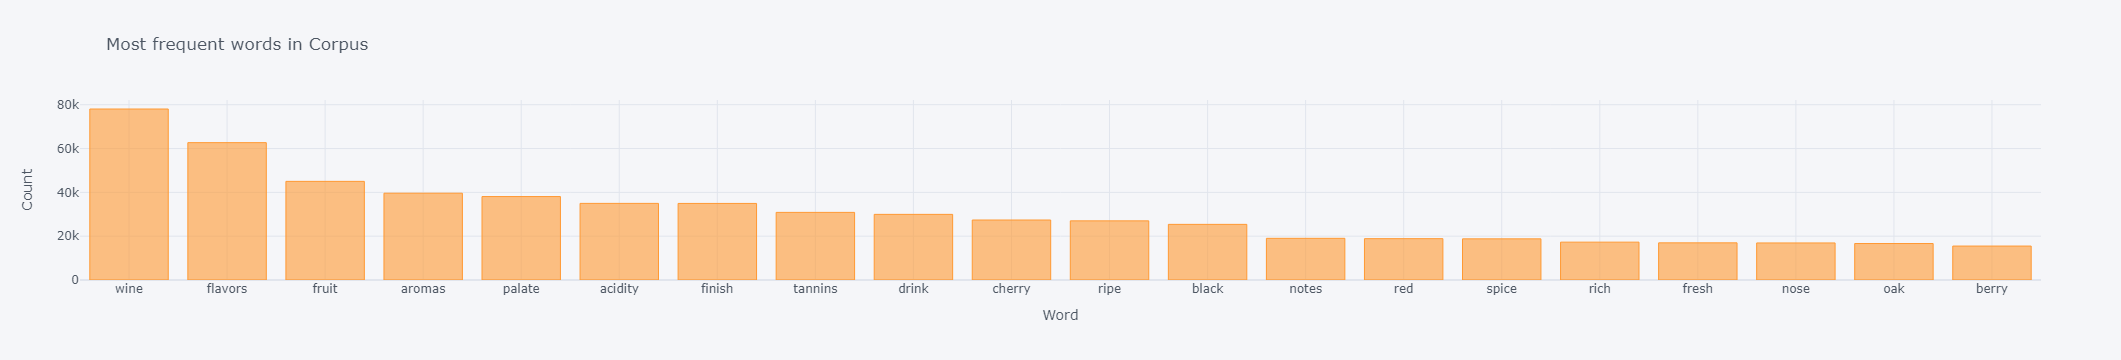

In [44]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

#### Prepare textual data only for Test

In [45]:
test_df, train_df = train_test_split(wine_reviews_desc, test_size=0.8, random_state=42)
train_df.shape, test_df.shape

((103977, 14), (25994, 14))

In [46]:
print(words_df.sort_values(by="wordImportance", ascending=False).head())
words_df.sample(5)

      word  wordCount  wordImportance  wordImportanceRelative
0     wine      78041        1.751094                1.000000
1  flavors      62683        1.406489                0.803206
2    fruit      45018        1.010120                0.576851
3   aromas      39613        0.888842                0.507592
4   palate      38083        0.854511                0.487987


,word,wordCount,wordImportance,wordImportanceRelative
11666,barbie,6,0.000135,0.000077
22005,aces,2,0.000045,0.000026
40430,jasmineextract,1,0.000022,0.000013
1593,hickory,235,0.005273,0.003011
9958,minervois,8,0.000180,0.000103


In [47]:
k = 5
print(words_df[words_df.wordCount <=k].shape)
print(words_df[words_df.wordCount >k].shape)
most_pop_words_df = words_df[words_df.wordCount >k]
most_pop_words_df.shape

(32284, 4)
(12283, 4)


(12283, 4)

In [48]:
clean_vocab = set(most_pop_words_df.word)

In [49]:
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)
train_bow_counts = count_vect.fit_transform(train_df.description_pure)
test_bow_counts = count_vect.transform(test_df.description_pure)
train_bow_counts.shape, test_bow_counts.shape

C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



((103977, 12283), (25994, 12283))

In [50]:
tf_idf_vectorizer = TfidfVectorizer(vocabulary = clean_vocab)
train_bow_tfidf = tf_idf_vectorizer.fit_transform(train_df.description_pure)
test_bow_tfidf = tf_idf_vectorizer.transform(test_df.description_pure)
train_bow_tfidf.shape, test_bow_tfidf.shape

((103977, 12283), (25994, 12283))

#### Text Classification

In [51]:
%%capture

UsageError: %%capture is a cell magic, but the cell body is empty.


In [52]:
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
model1 = Ridge(alpha=10)
reg = model1.fit(X=train_bow_tfidf, y=train_df.points)
#reg.score(train_bow_tfidf, train_df.points)

In [54]:
predicted_points = reg.predict(test_bow_tfidf)

In [55]:
reg.score(test_bow_tfidf, test_df.points)

0.6431285268845647

In [56]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(test_df.points, predicted_points))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_df.points, predicted_points))

Mean squared error: 3.29
Coefficient of determination: 0.64


In [57]:
points_predicted = reg.predict(test_bow_tfidf)
print("Mean squared error: %.2f" % mean_squared_error(test_df.points, points_predicted))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_df.points, points_predicted))
predicted_df = DataFrame()
predicted_df["actual"] = test_df.points
predicted_df["predicted"] = points_predicted
predicted_df.sample(10)

Mean squared error: 3.29
Coefficient of determination: 0.64


,actual,predicted
60233,91,88.333611
32089,89,88.286112
20951,84,87.289269
54219,87,86.884327
38285,90,88.802624
126643,89,89.912450
75787,85,83.747517
108896,88,90.343115
94686,85,86.841956
5424,88,89.543197


In [58]:
import plotly_express as px

rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
weights = model1.coef_.flatten()
words = [rev_dict[i] for i in range(len(weights))]
feature_weights = DataFrame({'word': words, 'weight': weights, 'absW': abs(weights)})
feature_weights.sort_values(by = 'absW', ascending = False, inplace = True)
feature_weights.head(10)

,word,weight,absW
805,beautiful,6.566854,6.566854
4639,gorgeous,6.213936,6.213936
2245,complex,5.630379,5.630379
806,beautifully,5.567378,5.567378
5298,impressive,5.453304,5.453304
9237,sample,5.267896,5.267896
6152,long,5.240126,5.240126
5760,lacks,-5.204282,5.204282
9711,simple,-5.080640,5.080640
10397,stunning,4.947707,4.947707


In [59]:
model2 = Ridge(alpha=10)
reg = model2.fit(X=train_bow_counts, y=train_df.points)
reg.score(train_bow_counts, train_df.points)

0.7332897217761966

In [60]:
points_predicted = reg.predict(test_bow_counts)
print("Mean squared error: %.2f" % mean_squared_error(test_df.points, points_predicted))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_df.points, points_predicted))

Mean squared error: 2.89
Coefficient of determination: 0.69


### Full Pipeline

In [61]:
x = reviews.drop(columns={'points'})
y = reviews['points']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(X_train.shape), print(X_train.columns)
print(y_train.shape)
print(X_test.shape, y_test.shape)
print(X_test.columns)

(103925, 6)
Index(['country', 'description', 'price', 'province', 'taster_name',
       'variety'],
      dtype='object')
(103925,)
(25982, 6) (25982,)
Index(['country', 'description', 'price', 'province', 'taster_name',
       'variety'],
      dtype='object')


In [62]:
from sklearn.preprocessing import FunctionTransformer
text_features = ['description']

categorical_features = ['country', 'province','taster_name','variety']
numerical_features = ['price']

# Create categorical and numerical transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

text_transformer = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    #("vect", CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)),
    ("tfidf", TfidfVectorizer(vocabulary=clean_vocab)),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# Combine transformers using ColumnTransformer
wine_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('txt', text_transformer, text_features)
], remainder='drop')

In [63]:
X_train.columns

Index(['country', 'description', 'price', 'province', 'taster_name',
       'variety'],
      dtype='object')

In [64]:
params = text_transformer.get_params()
tfidf_params = params["tfidf"].get_params()

In [65]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# Create a full pipeline with a classifier with text
full_pipeline = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('classifier', Ridge(alpha=10.0))
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'pr...
                                                                                               'able',
                                                                                               'ably',
                                                                                               'abound',
                                                                                               'abounds',
                                                                                               'abouriou',
                                                                                               'aboveaverage',
                                                                                               'abrasive',
                                                                                               'abrupt',
                                                                                               'abruptly',
                                                                                               'abruzzo',
                                                                                               'absence',
                                                                                               'absent',
                                                                                               'absolute',
                                                                                               'absolutely',
                                                                                               'absorb',
                                                                                               'absorbed',
                                                                                               'abundance',
                                                                                               'abundant',
                                                                                               'abundantly',
                                                                                               'abv',
                                                                                               'acacia', ...})),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001A63A0E8C10>))]),
                                                  ['description'])])),
                ('classifier', Ridge(alpha=10.0))])

In [66]:
print(X_train.iloc[2])
print(y_train[0:10])
X_train[0:10]
#print(X_train.head(2))


country                                                                                                                                                                                                                                                                 US
description    The famous growers branch out into their own wines with aplomb in this 100% varietal wine, tangoing with a much sought-after grape from their property. Sanguine and gamy, it's structured in good acidity and low oak, showing a succulence of blackberry.
price                                                                                                                                                                                                                                                                 48.0
province                                                                                                                                                                                               

,country,description,price,province,taster_name,variety
17869,Italy,"Aromas of black currant, plum, toast and espresso lead the nose on this young, soft Cabernet. The rich, easy-drinking palate doles out ripe black cherry and blackberry accented with notes of mocha and vanilla. Round tannins give it a smooth texture.",14.0,Central Italy,Kerin O’Keefe,unknown
50132,France,"Lovely cassis and jam scents are hampered by some slight musty aromas, which eventually give way to a blast of black licorice. Burnt sugar and cassis dominate the soft, sweetish palate that offers just a bit of grip. The short finish is reminiscent of a raspberry cordial. Drink up.",10.0,Languedoc-Roussillon,NaN,Cabernet Sauvignon
35920,US,"The famous growers branch out into their own wines with aplomb in this 100% varietal wine, tangoing with a much sought-after grape from their property. Sanguine and gamy, it's structured in good acidity and low oak, showing a succulence of blackberry.",48.0,California,Virginie Boone,Zinfandel
58109,Italy,"Delicate scents of violet, iris, woodland berry and baking spice abound on this firmly structured red. Made with 95% Sangiovese, the remaining 5% is Colorino and Malvasia Nera. The smooth palate doles out Morello cherry, crushed raspberry, cinnamon and a hint of chopped herb while a backbone of ...",19.0,Tuscany,Kerin O’Keefe,Red Blend
119940,US,"From the Cerise and Ridley vineyards, this wine explores two sites within the Anderson Valley. In taste it offers intense sour cherry, a flavor that finds its balance mid-palate, blossoming into smooth, spicy, full-bodied, oak-kissed goodness.",40.0,California,Virginie Boone,Pinot Noir
105501,US,"Woodsy and thickly textured, this Weir Pinot is balanced in just-ripe cherry goodness that neatly scrapes the edge of sour-ness. Fine earth and herbal overtones show off its varietal qualities, more typical of its warmer climate than the Deep End of Anderson Valley.",50.0,California,Virginie Boone,Pinot Noir
91886,US,"A rare Pinot Noir rosé from Washington state, this is unabashedly ripe and pink, but not at all sugary. It offers a burst of strawberry and watermelon candy flavors, like a good, long lasting taste of saltwater taffy.",20.0,Washington,Paul Gregutt,Rosé
119918,Argentina,"Everything about this Tempranillo-led blend rings true. It's full and flush on the nose, with clean berry and snappy tomato and spice notes. The mouthfeel is wiry and bold, with darts of acidity. Flavors span the red-berry spectrum, while the finish condenses in juicy, classy fashion. Drink thro...",28.0,Mendoza Province,Michael Schachner,Red Blend
18126,US,"This new Mistral is roughly half Grenache, the rest a mix of Syrah and four other grapes. It's immediately appealing, loaded with brown spices, plum cake, raisins and chocolate.",29.0,Washington,Paul Gregutt,Rhône-style Red Blend
81996,US,"Harvested at 22.6 degrees brix, this bright and spicy Dolcetto does not reach too far. It's tart, with fruit flavors that suggest wild berries and pomegranate, and tannins that are firm but never green. A fine quaffing wine.",20.0,Oregon,Paul Gregutt,Dolcetto


In [ ]:
# Fit the pipeline to the training data
full_pipeline.fit(X_train, y_train)

# Evaluate the pipeline on the test data
#accuracy = full_pipeline.score(X_test, y_test)
#print(f"Test accuracy: {accuracy:.3f}")

In [68]:
#score of training
full_pipeline.score(X_train, y_train)

0.715489974533287

In [69]:
#score of test
full_pipeline.score(X_test, y_test)

0.6969388295241227

In [70]:
test_predict = full_pipeline.predict(X_test)

In [71]:
test_predict_actual = DataFrame(zip(test_predict, y_test, X_test.description, X_test.province, X_test.taster_name, X_test.country, X_test.variety), columns=['predict', 'actual', 'description', 'province', 'tester_name', 'country', 'variety'])

In [72]:
test_predict_actual['abs_error'] = abs(test_predict_actual.predict - test_predict_actual.actual)
#test_predict_actual.sort_values(by=['abs_error'], ascending=False).head(50)

In [73]:
sum(abs(test_predict_actual.predict - test_predict_actual.actual))/len(test_predict_actual)

1.3123870404548525

In [74]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(test_predict_actual.actual, test_predict_actual.predict))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_predict_actual.actual, test_predict_actual.predict))

Mean squared error: 2.85
Coefficient of determination: 0.70


#### GridSearch to find most efficient apha and classifier

In [123]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

# Create a full pipeline with a classifier with text
pipeline_no_classifier = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    #('dimension_reduction', 'passthrogh'),
    ('classifier', 'passthrogh')
])
pipeline_no_classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'pr...
                                                                                               'ability',
                                                                                               'able',
                                                                                               'ably',
                                                                                               'abound',
                                                                                               'abounds',
                                                                                               'abouriou',
                                                                                               'aboveaverage',
                                                                                               'abrasive',
                                                                                               'abrupt',
                                                                                               'abruptly',
                                                                                               'abruzzo',
                                                                                               'absence',
                                                                                               'absent',
                                                                                               'absolute',
                                                                                               'absolutely',
                                                                                               'absorb',
                                                                                               'absorbed',
                                                                                               'abundance',
                                                                                               'abundant',
                                                                                               'abundantly',
                                                                                               'abv',
                                                                                               'acacia', ...})),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001A63A0E8C10>))]),
                                                  ['description'])])),
                ('classifier', 'passthrogh')])

In [76]:
param_grid = [
    {        
        'preprocessor__txt__tfidf__max_features': [500,1000,2000,5000,10000],
        'classifier__alpha': [0.001, 0.01],
        'classifier': [Lasso()],
    },
    {
        'preprocessor__txt__tfidf__max_features': [500,1000,2000,5000,10000],
        'classifier__alpha': [1, 10,100],
        'classifier': [Ridge()],
    }
]

In [78]:
from sklearn.model_selection import GridSearchCV
full_pipeline_grid_search = GridSearchCV(pipeline_no_classifier, param_grid = param_grid, cv=3, scoring='r2', verbose=5)
full_pipeline_grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_out...
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001A63A0E8C10>))]),
                                                                         ['description'])])),
                                       ('classifier', 'passthrogh')]),
             param_grid=[{'classifier': [Lasso()],
                          'classifier__alpha': [0.001, 0.01],
                          'preprocessor__txt__tfidf__max_features': [500, 1000,
                                                                     2000, 5000,
                                                                     10000]},
                         {'classifier': [Ridge()],
                          'classifier__alpha': [1, 10, 100],
                          'preprocessor__txt__tfidf__max_features': [500, 1000,
                                                                     2000, 5000,
                                                                     10000]}],
             scoring='r2', verbose=5)

In [79]:
full_pipeline_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END classifier=Lasso(), classifier__alpha=0.001, preprocessor__txt__tfidf__max_features=500;, score=0.574 total time= 4.4min
[CV 2/3] END classifier=Lasso(), classifier__alpha=0.001, preprocessor__txt__tfidf__max_features=500;, score=0.579 total time= 4.4min
[CV 3/3] END classifier=Lasso(), classifier__alpha=0.001, preprocessor__txt__tfidf__max_features=500;, score=0.562 total time= 2.8min
[CV 1/3] END classifier=Lasso(), classifier__alpha=0.001, preprocessor__txt__tfidf__max_features=1000;, score=0.574 total time= 4.2min
[CV 2/3] END classifier=Lasso(), classifier__alpha=0.001, preprocessor__txt__tfidf__max_features=1000;, score=0.579 total time= 4.2min
[CV 3/3] END classifier=Lasso(), classifier__alpha=0.001, preprocessor__txt__tfidf__max_features=1000;, score=0.562 total time= 4.8min
[CV 1/3] END classifier=Lasso(), classifier__alpha=0.001, preprocessor__txt__tfidf__max_features=2000;, score=0.574 total time= 4.0m

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_out...
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001A63A0E8C10>))]),
                                                                         ['description'])])),
                                       ('classifier', 'passthrogh')]),
             param_grid=[{'classifier': [Lasso()],
                          'classifier__alpha': [0.001, 0.01],
                          'preprocessor__txt__tfidf__max_features': [500, 1000,
                                                                     2000, 5000,
                                                                     10000]},
                         {'classifier': [Ridge(alpha=1)],
                          'classifier__alpha': [1, 10, 100],
                          'preprocessor__txt__tfidf__max_features': [500, 1000,
                                                                     2000, 5000,
                                                                     10000]}],
             scoring='r2', verbose=5)

In [112]:
cols = [ 'param_classifier', 'param_classifier__alpha','param_preprocessor__txt__tfidf__max_features', 'std_test_score', 'rank_test_score', 'mean_test_score', ]
cv_results_df = pd.DataFrame(full_pipeline_grid_search.cv_results_)
cv_results_df.sort_values(by = 'mean_test_score', ascending=False)[cols]

,param_classifier,param_classifier__alpha,param_preprocessor__txt__tfidf__max_features,std_test_score,rank_test_score,mean_test_score
12,Ridge(alpha=1),1,2000,0.001966,1,0.719520
11,Ridge(alpha=1),1,1000,0.001966,1,0.719520
14,Ridge(alpha=1),1,10000,0.001966,1,0.719520
13,Ridge(alpha=1),1,5000,0.001966,1,0.719520
10,Ridge(alpha=1),1,500,0.001966,1,0.719520
19,Ridge(alpha=1),10,10000,0.004222,6,0.683245
18,Ridge(alpha=1),10,5000,0.004222,6,0.683245
17,Ridge(alpha=1),10,2000,0.004222,6,0.683245
16,Ridge(alpha=1),10,1000,0.004222,6,0.683245
15,Ridge(alpha=1),10,500,0.004222,6,0.683245


In [103]:
y_actual = full_pipeline_grid_search.predict(X_test)

In [116]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_actual))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_actual))
predicted_df1 = DataFrame()
predicted_df1["actual"] = y_test
predicted_df1["predicted"] = y_actual
predicted_df1["price"] = X_test.price
predicted_df1["error"] = abs(y_test - y_actual)
predicted_df1.sort_values(by="error", ascending=False).head(10)

Mean squared error: 2.52
Coefficient of determination: 0.73


,actual,predicted,price,error
15840,96,119.956522,2500.0,23.956522
65352,97,112.462419,2000.0,15.462419
89478,94,105.916273,1100.0,11.916273
1575,96,107.553862,1300.0,11.553862
111755,100,111.331040,1500.0,11.331040
108484,94,102.766753,800.0,8.766753
41955,92,83.513645,19.0,8.486355
113581,94,101.819581,1125.0,7.819581
51978,92,99.740463,750.0,7.740463
1571,96,103.654567,1200.0,7.654567


In [139]:
full_pipeline2 = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('param_reduction', PCA()),
    ('classifier', Ridge()),
    
])


param_grid2 = [
    {        
        'param_reduction__n_components': [500, 2000, 10000],
        'classifier__alpha': [0.01, 0.1, 0.5],
    }
]

In [140]:
from sklearn.model_selection import GridSearchCV
full_pipeline_grid_search2 = GridSearchCV(full_pipeline2, param_grid = param_grid2, cv=3, scoring='r2', verbose=5)
full_pipeline_grid_search2

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_out...
                                                                                                                      'absorb',
                                                                                                                      'absorbed',
                                                                                                                      'abundance',
                                                                                                                      'abundant',
                                                                                                                      'abundantly',
                                                                                                                      'abv',
                                                                                                                      'acacia', ...})),
                                                                                         ('toarray',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001A63A0E8C10>))]),
                                                                         ['description'])])),
                                       ('param_reduction', PCA()),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier__alpha': [0.01, 0.1, 0.5],
                          'param_reduction__n_components': [500, 2000, 10000]}],
             scoring='r2', verbose=5)

In [ ]:
full_pipeline_grid_search2.fit(X_train, y_train)

#### Try to limit the range of price to 80-100

In [ ]:
from sklearn.metrics import make_scorer
def mean_abs_error(y_true, y_predict):
    alpha = 0.5
    loss_penalty = alpha * np.mean(np.maximum(0, y_pred - 100)) + alpha * np.mean(np.maximum(0, 80 - y_pred))
    return np.abs(np.array(y_true)-np.array(y_predict)).mean()

mean_abs_scorer = make_scorer(mean_abs_error, greater_is_better=False)


In [ ]:
rcv = RidgeCV(alphas, scoring=mean_abs_scorer, cv=5).fit(X_train, y_train)